In [7]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [8]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

## 1.Data(Preparing and loading)
Data can be almost anything... in machine learning.

*   Excel speadsheet
*   Images of any kind
*   Videos(Youtube has lots of data..)
*   Audio like songs or podcasts
*   DNA
*   Text

Machine learning is a game pf two parts:

1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.









In [9]:
## Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim =1)
y = weight*X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [10]:
len(X),len(y)

(50, 50)

### Splitting data into training and test sets

In [11]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

#### Let's create a function to visualize it.

In [12]:
def plot_predictions(train_data =X_train,
                     train_labels= y_train,
                     test_data = X_test,
                     test_labels  = y_test,
                     predictions =None):
    
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize =(10,7))

  # plot training data in blue
  plt.scatter(train_data, train_labels, c = 'b',s =4, label = "Training data")
  
  # plot test data in green
  plt.scatter(test_data, test_labels,c='g',s = 4, label='Testing data')

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c= 'r',s=4,label = predictions)
  
  plt.legend(prop={"size":14})

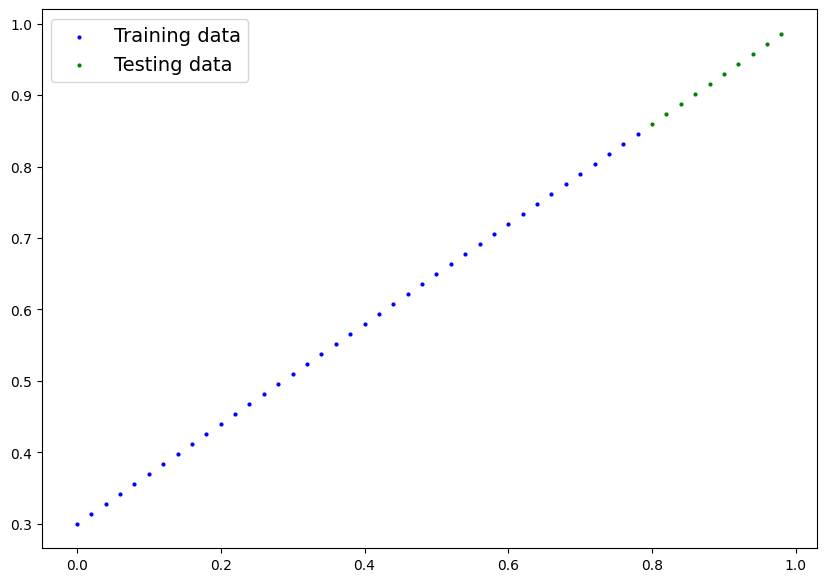

In [13]:
plot_predictions();

### Creating our First Pytorch Model

In [14]:

# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials
Almost everything in a PyTorch neural network comes from torch.nn,


*   **nn.Module** contains the larger building blocks (layers)
*  **nn.Parameter** contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
* **forward()** tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
*   **torch.optim **contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data




#### Checking the contents of a PyTorch model

In [15]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)
# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()
# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [16]:
# We can get the state of the model using .state_dict()
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

In [17]:
#make predictions with model
with torch.inference_mode():
  y_preds = model_0(X_test)
  
# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [18]:
# Check the predictions
print(f'Number of testing samples: {len(X_test)}')
print(f'Number of predictions made: {len(y_preds)}')
print(f'Predicted values:\n{y_preds}')

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


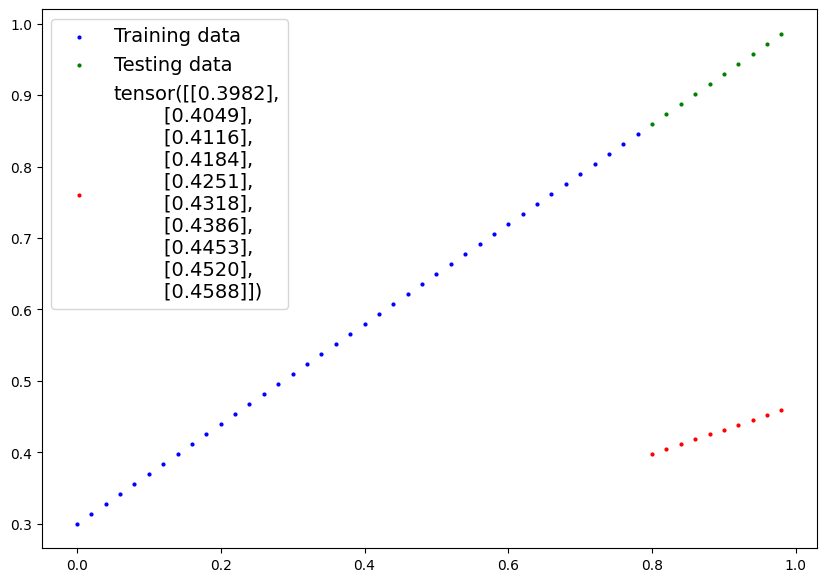

In [19]:
plot_predictions(predictions = y_preds)
#Those predictions look pretty bad...
#Time to change that.

### 3.Train model
Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

###Creating a loss function and optimizer in PyTorch

**Loss Function**: Measures how wrong your models predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.PyTorch has plenty of built-in loss functions in torch.nn.Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()). Binary cross entropy for binary classification problems (torch.nn.BCELoss()).

**Optimizer**: 	Tells your model how to update its internal parameters to best lower the loss.You can find various optimization function implementations in torch.optim.Stochastic gradient descent (torch.optim.SGD()). Adam optimizer (torch.optim.Adam()).


In [20]:
## Create a  Loss function
loss_fn = nn.L1Loss()

# Create a optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),#parameters of target model to optimize
                            lr = 0.01)# learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating a optimizer Loop in Pytorch
We created a loss function. In this part, we will create a training loop(and testing loop).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

In code part, we will see training and testing loops. We'll build the following steps. We will notice that the testing loop doesn't contain performing backpropagation(*loss.backward()*) or stepping the optimizer(*optimizer.step()*). because during the test section, there are no parameters to change.

In [21]:
torch.manual_seed(42)

epochs = 100 

train_loss_values = []
test_loss_values = []
train_pred = []
epoch_count = []

for epoch in range(epochs):

  model_0.train()

  y_pred = model_0(X_train)
 

  loss = loss_fn(y_pred,y_train)

  # zero grad of the optimizer
  optimizer.zero_grad()

  # Loss backwards
  loss.backward()

  # Progress the optimizer
  optimizer.step()

  ## Testing steps

  # model eval
  model_0.eval()

  with torch.inference_mode():
    # Forward pass on test data
    test_pred = model_0(X_test)

    #  Calculate loss on test data 
    test_loss = loss_fn(test_pred,y_test.type(torch.float))

    # Print out whats happening
    if epoch % 10 == 0:

      epoch_count.append(epoch)
      train_loss_values.append(loss.detach().numpy())
      test_loss_values.append(test_loss.detach().numpy())
      
      print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
      

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


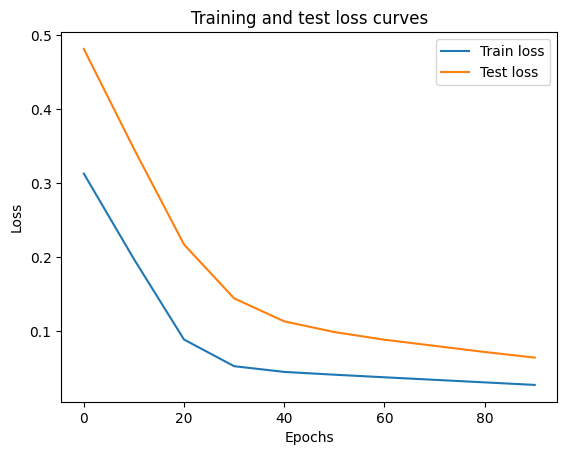

In [22]:
# Plot the loss curves
plt.plot(epoch_count,train_loss_values, label = "Train loss")
plt.plot(epoch_count,test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [23]:
# Find our model's learned parameters
print('The model learned the following values for weights and bias: ')
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f'Weights: {weight}, bias: {bias}')

The model learned the following values for weights and bias: 
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
Weights: 0.7, bias: 0.3


### Making predictions with a trained PyTorch model (inference)
There are 3 things to do when predicting with a Pytorch model


1.   Set the model in evaluation mode (model.eval()).
2. Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
3. All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).



In [24]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

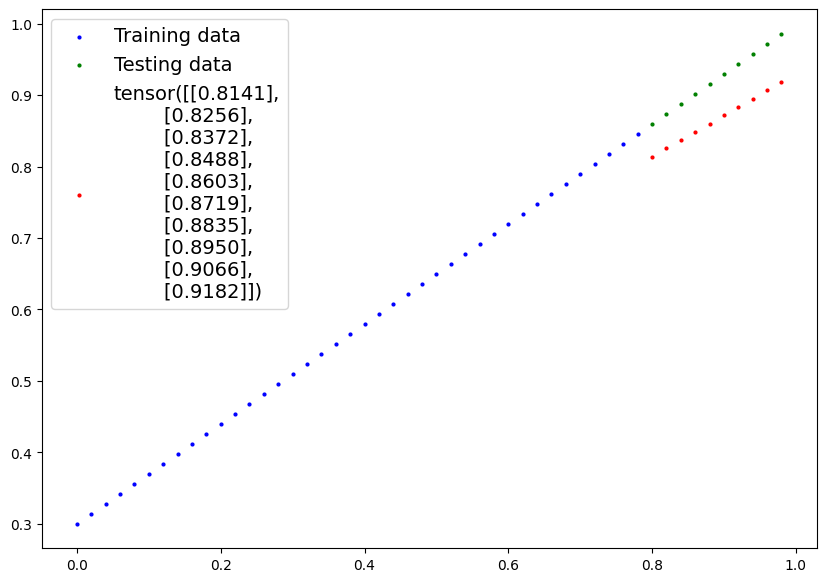

In [25]:
plot_predictions(predictions = y_preds)

 ### Saving and loading a Pytorch model
**torch.save** Saves an object to a disk file.

**torch.load** Loads an object saved with torch.save() from a file.

**torch.nn.Module.load_state_dict** Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [26]:
### Saving a Pytorch model's state_dict()

from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3.Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), 
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [27]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1207 Apr 25 13:55 models/01_pytorch_workflow_model_0.pth


### Putting it All Together 

In [28]:
import torch 
from torch import nn
import matplotlib.pyplot as plt


In [29]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using device: {device}')

Using device: cuda


In [30]:
weight = 0.7
bias = 0.3

X = torch.arange(0,1, 0.02).unsqueeze(dim = 1)
y = weight * X + bias
X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [31]:
# Split data
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

len(X_train), len(y_train), len(X_test),len(y_test)

(40, 40, 10, 10)

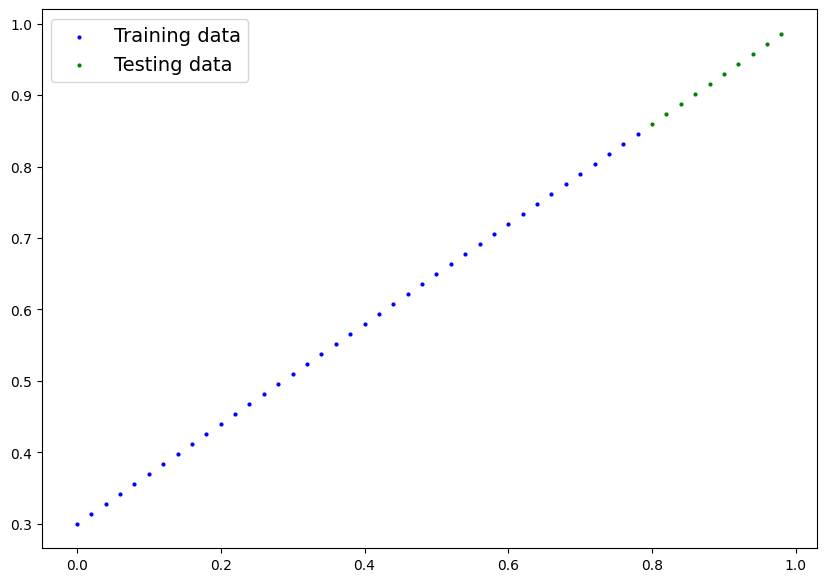

In [33]:
plot_predictions(X_train,y_train,X_test,y_test)